# Building a classifier for detecting tuberculosis in chest X-rays
By Jonathan Feenstra (s1024219) and Justin Huberts (s1030368)

In this project we attempt to construct a binary Extreme Learning Machine (ELM) classifier to detect tuberculosis in lung X-rays. The U.S. National Library of Medicine has made two datasets of postero-anterior chest radiographs available which we will use to train and test our model: the Montgomery County Set and the Shenzen Set (Jaeger et al., 2014).

The datasets are available for download at [https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/)

## Sources
- Jaeger, S., Candemir, S., Antani, S., Wáng, Y., Lu, P., & Thoma, G. (2014). Two public chest X-ray datasets for computer-aided screening of pulmonary diseases. _Quantitative Imaging In Medicine And Surgery, 4_(6), 475-477.

In [1]:
import glob
import os
import sys
import warnings
from random import sample

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from hpelm import ELM
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image, ImageChops
from scipy import ndimage
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             recall_score, roc_curve)
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# Print data directory
print(os.listdir('./Data'))

['ChinaSet_AllFiles', 'Inverted', 'MontgomerySet', 'Suppressed']


## Some example images

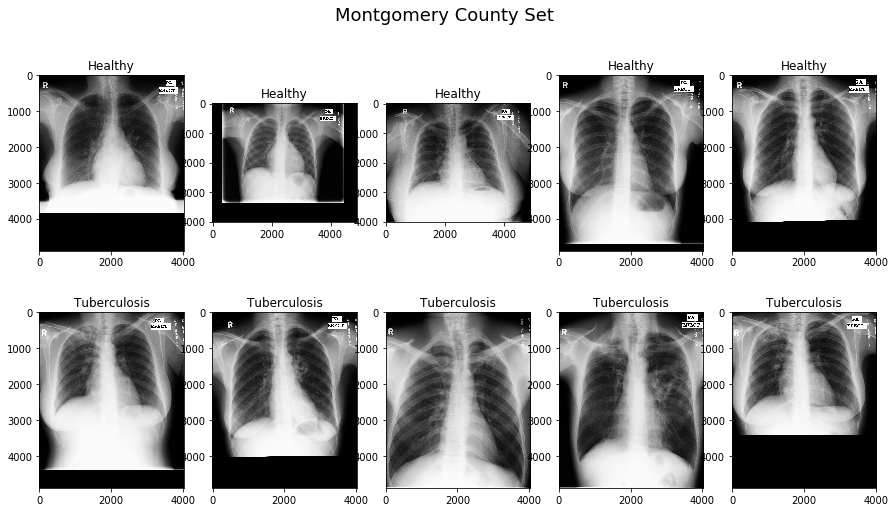

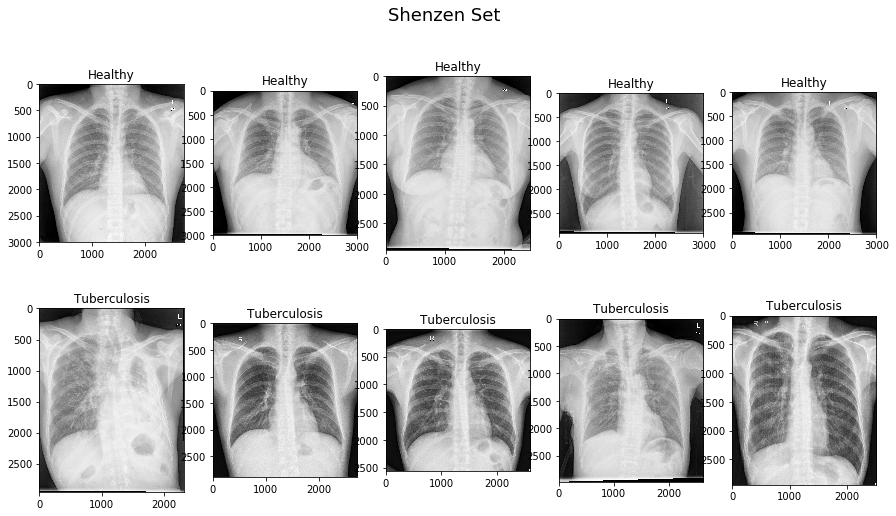

In [2]:
# Datasets
mont_tb_neg = glob.glob('Data/MontgomerySet/CXR_png/*_0.png')
mont_tb_pos = glob.glob('Data/MontgomerySet/CXR_png/*_1.png')
shen_tb_neg = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_0.png')
shen_tb_pos = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_1.png')

mont_set = mont_tb_neg + mont_tb_pos
shen_set = shen_tb_neg + shen_tb_pos

# Take samples (5 TB-positive and 5 TB-negative per set)
mont_tb_neg_sample = sample(mont_tb_neg, 5)
mont_tb_pos_sample = sample(mont_tb_pos, 5)
shen_tb_neg_sample = sample(shen_tb_neg, 5)
shen_tb_pos_sample = sample(shen_tb_pos, 5)

# Plot samples of Montgomery County Set images
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Set', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

# Plot samples of Shenzen Set images
shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Set', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
Since all Montgomery County images have a default size of either 4,020×4,892 or 4,892×4,020 pixels, while the actual X-ray size varies, some images contain empty space (black background). For the Shenzen Set the image sizes vary more. Furthermore, there is not always an obvious way to tell whether the X-ray is from a tuberculosis patient or a healthy person.

## Pre-processing
### Step 1: Trim the Montgomery set images to remove empty space
The following Python code was used to trim the images:
```
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
        

for filename in mont_set:
    trim(Image.open(filename)).save(filename.replace('CXR_png', 'Trimmed'))
```

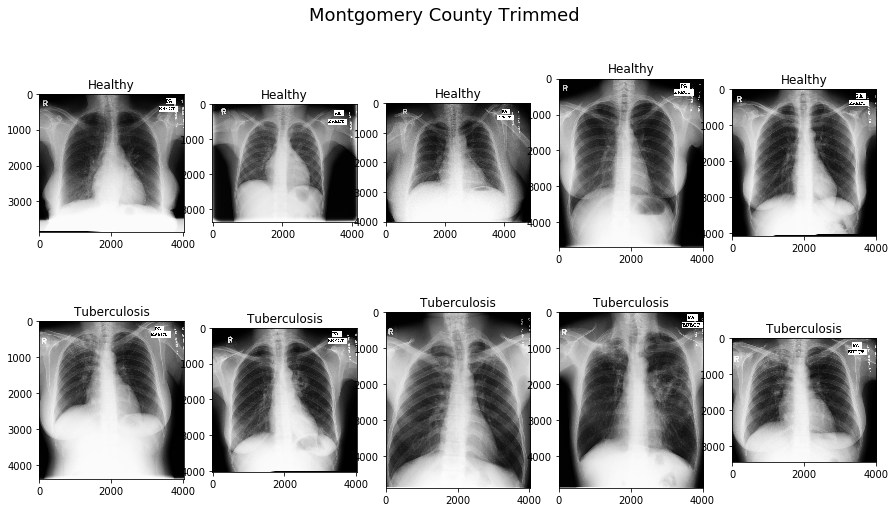

In [3]:
mont_set = glob.glob('Data/MontgomerySet/Trimmed/*.png')

# Plot samples of trimmed Montgomery County Set images
trim_fig = plt.figure(figsize=(15, 8))
trim_fig.suptitle('Montgomery County Trimmed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(Image.open(filename.replace('CXR_png', 'Trimmed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
Now that the empty spaces of the images are trimmed away, the Montgomery County image sizes vary as well.

### Step 2: Compress all images to 1024×1024 pixels to prepare the images for bone shadow suppression
The following Python code was used to compress the images (using anti-aliasing):
```
for i, filename in enumerate(mont_set):
    Image.open(filename).resize((1024, 1024), Image.ANTIALIAS).save(
        filename.replace('Trimmed', 'Compressed'))

for i, filename in enumerate(shen_set):
    Image.open(filename).resize((1024, 1024), Image.ANTIALIAS).save(
        filename.replace('CXR_png', 'Compressed'))
```

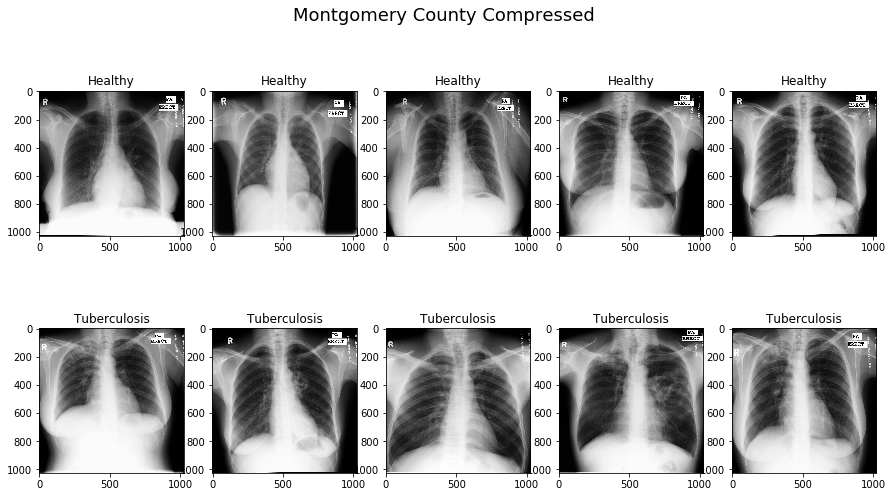

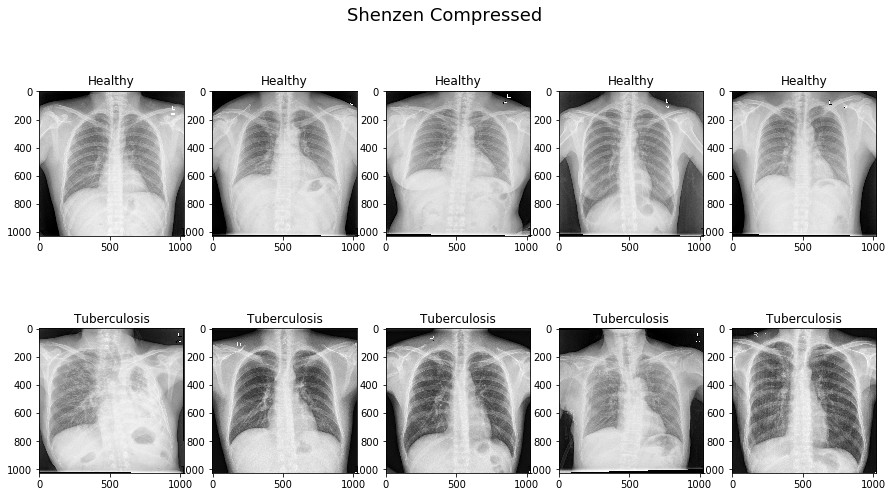

In [4]:
# Plot samples of compressed Montgomery County Set images
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Compressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(Image.open(filename.replace('CXR_png', 'Compressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

# Plot samples of compressed Shenzen Set images
shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Compressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(filename.replace('CXR_png',
                                        'Compressed')).convert('L')),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
As expected, all images are now 1024×1024 pixels, which has changed the horizontal/vertical scale a bit for all images that were not square-shaped. Hopefully this does not negatively affect the performance of the classifier.

### Step 3: Invert colors to prepare the images for bone shadow suppression
The following Python code was used to invert the colors of the images:
```
import os
import PIL.ImageOps

for filename in glob.glob('Data/MontgomerySet/Compressed/*.png') + glob.glob(
        'Data/ChinaSet_AllFiles/Compressed/*.png'):
    PIL.ImageOps.invert(
        Image.open(filename).convert('L')).save('Data/Inverted/' +
                                                os.path.basename(filename))
```

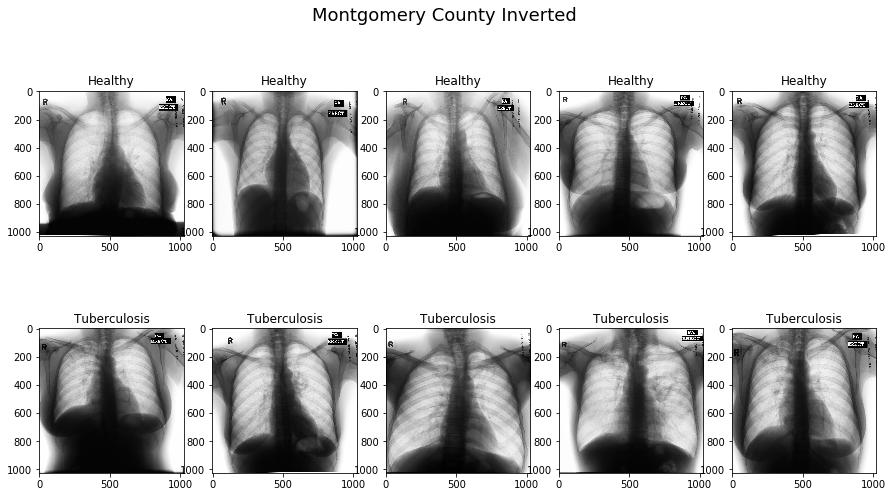

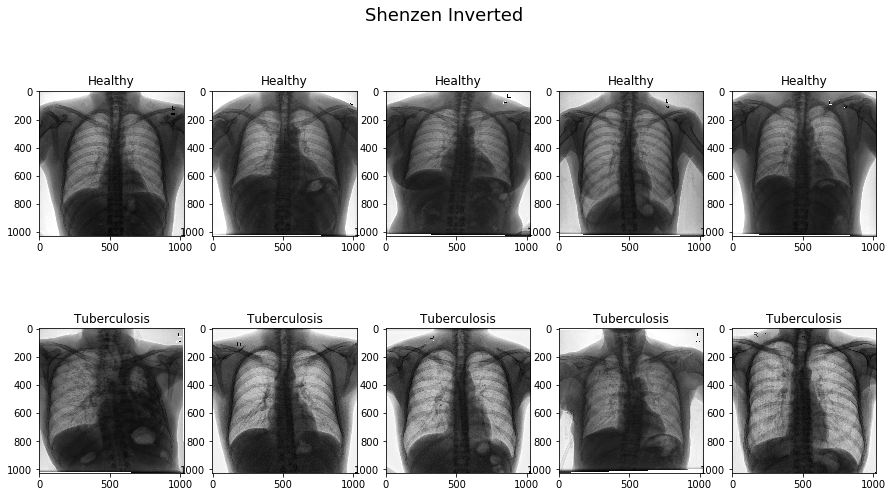

In [5]:
# Plot samples of inverted Montgomery County Set images
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Inverted', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(filename.replace('MontgomerySet/CXR_png', 'Inverted'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

# Plot samples of inverted Shenzen Set images
shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Inverted', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('ChinaSet_AllFiles/CXR_png',
                                 'Inverted')).convert('L')),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
The colors were inverted properly, which has made the lungs brighter than the other parts of the chest. Remarkably, the lungs in the Montgomery County Set appear to look brighter than those in the Shenzen Set.

### Step 4: Apply bone shadow suppression
For this step we used the pretrained model from  [https://github.com/hmchuong/ML-BoneSuppression](https://github.com/hmchuong/ML-BoneSuppression) (version 1) to suppress the bone shadows of the inverted images using the following shell script (BASH):
```
#!/bin/bash
for filename in ./Data/Inverted/*
do
    python test.py --input \$filename --output "\${filename/Inverted/Suppressed}"
done
```
Note that executing this script requires some of the files from the [GitHub repository](https://github.com/hmchuong/ML-BoneSuppression).

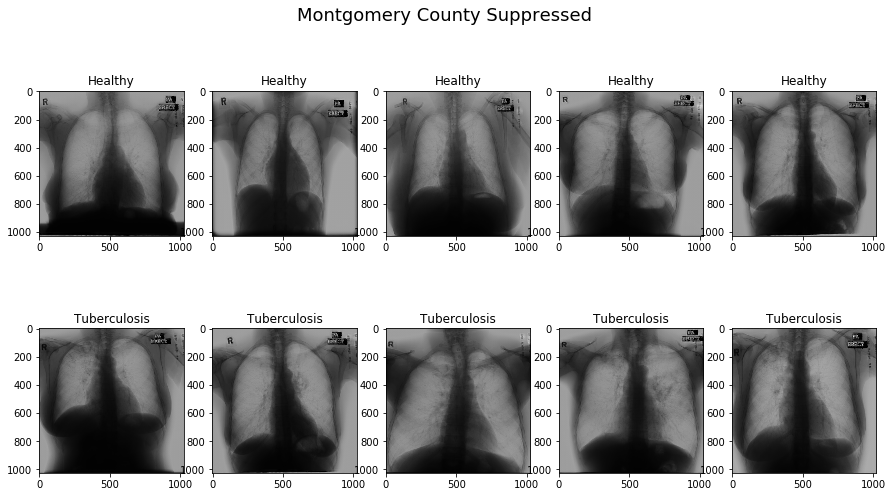

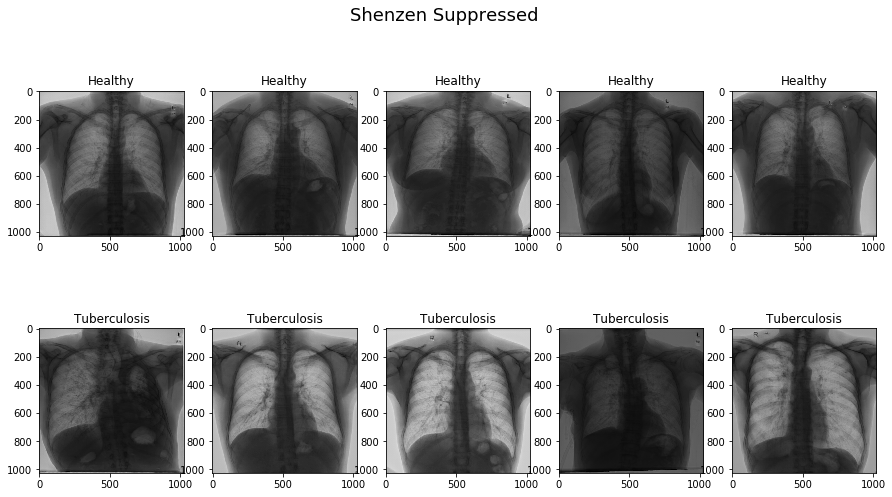

In [6]:
# Plot samples of bone shadow suppressed Montgomery County Set images
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Suppressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('MontgomerySet/CXR_png', 'Suppressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

# Plot samples of bone shadow suppressed Shenzen Set images
shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Suppressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('ChinaSet_AllFiles/CXR_png', 'Suppressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
The bone shadows have significantly been suppressed, especially for the Montgomery County Set.

## ELM classifier
A binary ELM classifier will be trained using the pre-processed images from the two datasets. It's performance will be evaluated by plotting an ROC-curve and a confusion matrix, as well as providing some relevant metrics.

Useful article: [https://ieeexplore.ieee.org/document/7140733](https://ieeexplore.ieee.org/document/7140733)

### With bone shadow suppression

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
--- Metrics when trained on full set ---



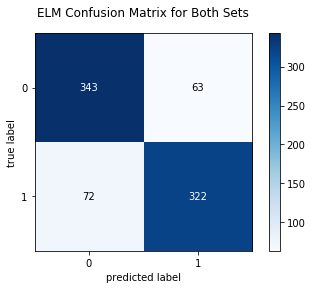

Accuracy: 0.83125
Recall: 0.817258883248731
F-measure: 0.8267008985879333
AUC: 0.8861993948638444
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.8297223422498885
train_recall 0.8164128272459618
train_f1 0.8252634747172103
test_accuracy 0.7464984763244258
test_recall 0.7392948717948717
test_f1 0.741931321525017
--- Metrics when trained on full set ---



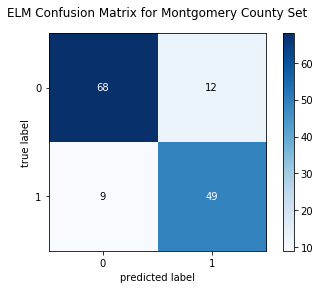

Accuracy: 0.8478260869565217
Recall: 0.8448275862068966
F-measure: 0.823529411764706
AUC: 0.8730603448275862
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.9943548387096774
train_recall 0.9923076923076923
train_f1 0.9932582947082478
test_accuracy 0.5236263736263737
test_recall 0.5599999999999999
test_f1 0.4824259074259074
--- Metrics when trained on full set ---



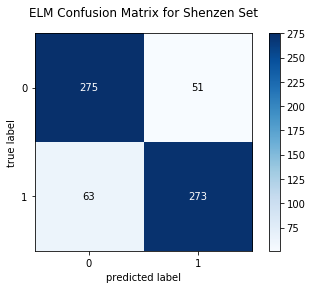

Accuracy: 0.8277945619335347
Recall: 0.8125
F-measure: 0.8272727272727272
AUC: 0.8875985977212972
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.8363551651816505
train_recall 0.8227526063864664
train_f1 0.8361894171293521
test_accuracy 0.7384385763490241
test_recall 0.7259358288770054
test_f1 0.7361369875694982


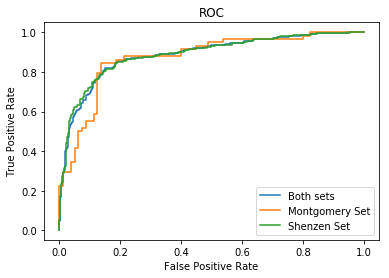

In [7]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def show_conf_matrix_and_metrics(y_true, y_pred, threshold, title):
    y_pred_classes = [0 if p < threshold else 1 for p in y_pred]
    plot_confusion_matrix(
        confusion_matrix(y_true, y_pred_classes), colorbar=True)
    plt.title(title)
    plt.show()
    print('Accuracy: {0}'.format(accuracy_score(y_true, y_pred_classes)))
    print('Recall: {0}'.format(recall_score(y_true, y_pred_classes)))
    print('F-measure: {0}'.format(f1_score(y_true, y_pred_classes)))


def apply_stratified_kfold(elm, k, X, y, threshold):
    train_accuracy, train_recall, train_f1 = [], [], []
    test_accuracy, test_recall, test_f1 = [], [], []
    skfold = StratifiedKFold(k)
    with HiddenPrints():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for train_index, test_index in skfold.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                elm.train(X_train, y_train)
                y_pred_train, y_pred_test = elm.predict(X_train), elm.predict(
                    X_test)
                y_pred_train_classes = [
                    0 if p < threshold else 1 for p in y_pred_train
                ]
                y_pred_test_classes = [
                    0 if p < threshold else 1 for p in y_pred_test
                ]
                train_accuracy.append(
                    accuracy_score(y_train, y_pred_train_classes))
                test_accuracy.append(
                    accuracy_score(y_test, y_pred_test_classes))
                train_recall.append(
                    recall_score(y_train, y_pred_train_classes))
                test_recall.append(recall_score(y_test, y_pred_test_classes))
                train_f1.append(f1_score(y_train, y_pred_train_classes))
                test_f1.append(f1_score(y_test, y_pred_test_classes))
    return {
        'train_accuracy': np.mean(train_accuracy),
        'train_recall': np.mean(train_recall),
        'train_f1': np.mean(train_f1),
        'test_accuracy': np.mean(test_accuracy),
        'test_recall': np.mean(test_recall),
        'test_f1': np.mean(test_f1),
    }


# Threshold value for classification (<= negative, > positive)
THRESHOLD = 0.5

# Load pre-processed images
mont_images = []
shen_images = []
mont_labels = []
shen_labels = []

for filename in glob.glob('Data/Suppressed/*.png'):
    img = np.frombuffer(
        Image.open(filename).resize((256, 256), Image.ANTIALIAS).tobytes(),
        dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        shen_images.append(img)
        shen_labels.append(int(os.path.splitext(filename)[0][-1]))
    elif os.path.basename(filename)[0] == 'M':
        mont_images.append(img)
        mont_labels.append(int(os.path.splitext(filename)[0][-1]))

X_both = np.array(mont_images + shen_images)
y_both = np.array(mont_labels + shen_labels, dtype=np.int64)

X_mont = np.array(mont_images)
y_mont = np.array(mont_labels, dtype=np.int64)

X_shen = np.array(shen_images)
y_shen = np.array(shen_labels, dtype=np.int64)

# Create ELM
elm = ELM(65536, 1)
elm.add_neurons(150, 'sigm')
elm.add_neurons(9, 'lin')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    elm.train(X_both, y_both)
    y_pred_both = elm.predict(X_both)
    y_pred_mont = elm.predict(X_mont)
    y_pred_shen = elm.predict(X_shen)

# Test ELM on both sets
fpr_both, tpr_both, threshold = roc_curve(y_both, y_pred_both)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(y_both, y_pred_both, THRESHOLD,
                             'ELM Confusion Matrix for Both Sets')
print('AUC: {0}'.format(auc(fpr_both, tpr_both)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_both = apply_stratified_kfold(elm, 10, X_both, y_both, THRESHOLD)
for k, v in skfold_both.items():
    print(k, v)

# Test ELM on Montgomery County Set
fpr_mont, tpr_mont, threshold = roc_curve(y_mont, y_pred_mont)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(y_mont, y_pred_mont, THRESHOLD,
                             'ELM Confusion Matrix for Montgomery County Set')
print('AUC: {0}'.format(auc(fpr_mont, tpr_mont)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_mont = apply_stratified_kfold(elm, 10, X_mont, y_mont, THRESHOLD)
for k, v in skfold_mont.items():
    print(k, v)

# Test ELM on Shenzen Set
fpr_shen, tpr_shen, threshold = roc_curve(y_shen, y_pred_shen)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(y_shen, y_pred_shen, THRESHOLD,
                             'ELM Confusion Matrix for Shenzen Set')
print('AUC: {0}'.format(auc(fpr_shen, tpr_shen)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_shen = apply_stratified_kfold(elm, 10, X_shen, y_shen, THRESHOLD)
for k, v in skfold_shen.items():
    print(k, v)

# ROC curve
plt.plot(fpr_both, tpr_both, label='Both sets')
plt.plot(fpr_mont, tpr_mont, label='Montgomery Set')
plt.plot(fpr_shen, tpr_shen, label='Shenzen Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')

plt.show()

### Without bone shadow suppression

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
--- Metrics when trained on full set ---



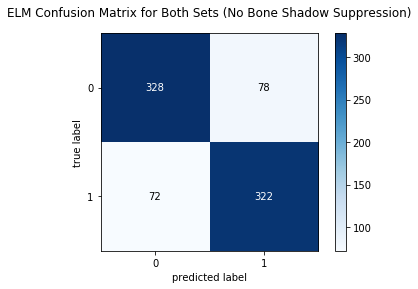

Accuracy: 0.8125
Recall: 0.817258883248731
F-measure: 0.8110831234256927
AUC: 0.8851554099672426
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.825274036022446
train_recall 0.8068170605554229
train_f1 0.8197505189879172
test_accuracy 0.7299185419596812
test_recall 0.7137179487179488
test_f1 0.7209338361367128
--- Metrics when trained on full set ---



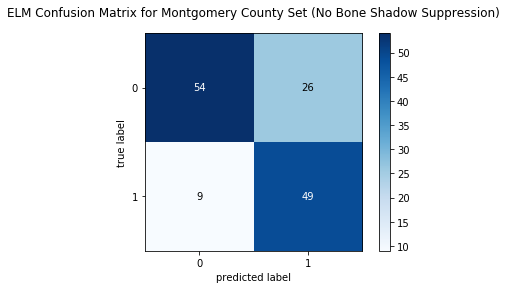

Accuracy: 0.7463768115942029
Recall: 0.8448275862068966
F-measure: 0.7368421052631579
AUC: 0.8364224137931034
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.9911483870967743
train_recall 0.9866110304789549
train_f1 0.989431700985099
test_accuracy 0.4928571428571429
test_recall 0.46333333333333326
test_f1 0.4231604506604506
--- Metrics when trained on full set ---



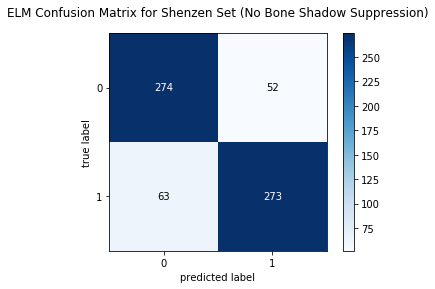

Accuracy: 0.8262839879154078
Recall: 0.8125
F-measure: 0.8260211800302573
AUC: 0.8956050978673677
--- Stratified K-fold metrics (k=10) ---

train_accuracy 0.8383702827864816
train_recall 0.8244049570519966
train_f1 0.8381196543504231
test_accuracy 0.7459012629161883
test_recall 0.740909090909091
test_f1 0.7468059857739994


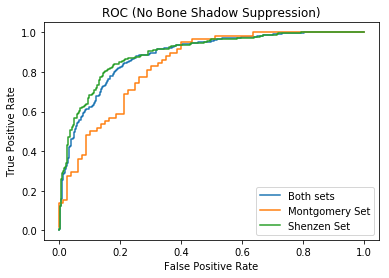

In [8]:
# Load pre-processed images (without bone shadow suppression)
mont_images_no_bss = []
shen_images_no_bss = []

for filename in glob.glob('Data/Inverted/*.png'):
    img = np.frombuffer(
        Image.open(filename).resize((256, 256), Image.ANTIALIAS).tobytes(),
        dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        shen_images_no_bss.append(img)
    elif os.path.basename(filename)[0] == 'M':
        mont_images_no_bss.append(img)

X_both_no_bss = np.array(mont_images_no_bss + shen_images_no_bss)
y_both_no_bss = np.array(mont_labels + shen_labels, dtype=np.int64)

X_mont_no_bss = np.array(mont_images_no_bss)
y_mont_no_bss = np.array(mont_labels, dtype=np.int64)

X_shen_no_bss = np.array(shen_images_no_bss)
y_shen_no_bss = np.array(shen_labels, dtype=np.int64)

# Create ELM
elm_no_bss = ELM(65536, 1)
elm_no_bss.add_neurons(150, 'sigm')
elm_no_bss.add_neurons(9, 'lin')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    elm_no_bss.train(X_both_no_bss, y_both_no_bss)
    y_pred_both_no_bss = elm_no_bss.predict(X_both_no_bss)
    y_pred_mont = elm_no_bss.predict(X_mont_no_bss)
    y_pred_shen = elm_no_bss.predict(X_shen_no_bss)

# Test ELM on both sets
fpr_both_no_bss, tpr_both_no_bss, threshold = roc_curve(
    y_both_no_bss, y_pred_both_no_bss)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(
    y_both_no_bss, y_pred_both_no_bss, THRESHOLD,
    'ELM Confusion Matrix for Both Sets (No Bone Shadow Suppression)')
print('AUC: {0}'.format(auc(fpr_both_no_bss, tpr_both_no_bss)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_both_no_bss = apply_stratified_kfold(elm, 10, X_both_no_bss,
                                            y_both_no_bss, THRESHOLD)
for k, v in skfold_both_no_bss.items():
    print(k, v)

# Test ELM on Montgomery County Set
fpr_mont_no_bss, tpr_mont_no_bss, threshold = roc_curve(
    y_mont_no_bss, y_pred_mont)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(
    y_mont_no_bss, y_pred_mont, THRESHOLD,
    'ELM Confusion Matrix for Montgomery County Set (No Bone Shadow Suppression)'
)
print('AUC: {0}'.format(auc(fpr_mont_no_bss, tpr_mont_no_bss)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_mont_no_bss = apply_stratified_kfold(elm, 10, X_mont_no_bss,
                                            y_mont_no_bss, THRESHOLD)
for k, v in skfold_mont_no_bss.items():
    print(k, v)

# Test ELM on Shenzen Set
fpr_shen_no_bss, tpr_shen_no_bss, threshold = roc_curve(
    y_shen_no_bss, y_pred_shen)

print('--- Metrics when trained on full set ---\n')
show_conf_matrix_and_metrics(
    y_shen_no_bss, y_pred_shen, THRESHOLD,
    'ELM Confusion Matrix for Shenzen Set (No Bone Shadow Suppression)')
print('AUC: {0}'.format(auc(fpr_shen_no_bss, tpr_shen_no_bss)))

print('--- Stratified K-fold metrics (k=10) ---\n')
skfold_shen_no_bss = apply_stratified_kfold(elm, 10, X_shen_no_bss,
                                            y_shen_no_bss, THRESHOLD)
for k, v in skfold_shen_no_bss.items():
    print(k, v)

# ROC curve
plt.plot(fpr_both_no_bss, tpr_both_no_bss, label='Both sets')
plt.plot(fpr_mont_no_bss, tpr_mont_no_bss, label='Montgomery Set')
plt.plot(fpr_shen_no_bss, tpr_shen_no_bss, label='Shenzen Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC (No Bone Shadow Suppression)')

plt.show()

### Observations
The ELM seems to perform reasonably well for this classification task, with an accuracy, recall and F-measure around 80% when tested on both sets together. When only testing the Montgomery County Set, the scores are a little bit lower (possibly because the ELM was trained on fewer images of this set). Surprisingly, bone shadow suppression does not affect the performance significantly. The stratified K-fold metrics suggest a decent generalization performance as well.

## Conclusion
Our ELM model can distinguish lung X-rays of TB-positive patients from X-rays of TB-negative patients with an accuracy, recall and F-measure around 80%, which has useful applications in computer-aided diagnosis.